In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import constants, units
from astropy.coordinates import Angle
from scipy.optimize import curve_fit
import pandas as pd
import os

In [2]:
rootdir = '/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/MUSE/'

In [3]:
plt.style.use('/Users/thepoetoftwilight/Documents/CUBS/Code/science.mplstyle')

Load in the MUSE FITS file

In [4]:
muse_fits = fits.open(rootdir + 'COMBINED_CUBE_MED_FINAL_vac.fits')

In [5]:
muse_fits.info()

Filename: /Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/MUSE/COMBINED_CUBE_MED_FINAL_vac.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1211   ()      
  1  DATA          1 ImageHDU        42   (337, 319, 3682)   float32   
  2  STAT          1 ImageHDU        43   (337, 319, 3682)   float32   


In [6]:
data_hdu = muse_fits[1]
var_hdu = muse_fits[2]

In [7]:
data_hdu.header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  337 / Axis lenght                                    
NAXIS2  =                  319 / Axis lenght                                    
NAXIS3  =                 3682 / Axis lenght                                    
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
EXTNAME = 'DATA    '           / This extension contains data values            
HDUCLASS= 'ESO     '           / class name (ESO format)                        
HDUDOC  = 'DICD    '           / document with class description                
HDUVERS = 'DICD version 6'     / version number (according to spec v2.5.1)      
HDUCLAS1= 'IMAGE   '        

In [8]:
var_hdu.header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  337 / Axis lenght                                    
NAXIS2  =                  319 / Axis lenght                                    
NAXIS3  =                 3682 / Axis lenght                                    
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
EXTNAME = 'STAT    '           / This extension contains data variance          
HDUCLASS= 'ESO     '           / class name (ESO format)                        
HDUDOC  = 'DICD    '           / document with class description                
HDUVERS = 'DICD version 6'     / version number (according to spec v2.5.1)      
HDUCLAS1= 'IMAGE   '        

Extract the MUSE cube as a 3-D array

In [9]:
spec_cube = data_hdu.data.copy()
var_cube = var_hdu.data.copy()

In [10]:
spec_cube.shape, var_cube.shape

((3682, 319, 337), (3682, 319, 337))

Extract the wavelength array

In [11]:
wav_0 = data_hdu.header['CRVAL3']
del_wav = data_hdu.header['CD3_3']

In [12]:
wav_arr = np.arange(wav_0, wav_0 + (spec_cube.shape[0]-1)*del_wav, del_wav)

Extract the RA array

In [13]:
RA_ref_pix = data_hdu.header['CRPIX1']-1
RA_ref_val = data_hdu.header['CRVAL1']
del_RA = data_hdu.header['CD1_1']

In [14]:
del_RA

-5.55555555555556e-05

In [15]:
RA_0_val = RA_ref_val - del_RA*RA_ref_pix

In [16]:
RA_arr = np.arange(RA_0_val, RA_0_val + spec_cube.shape[2]*del_RA, del_RA)

In [17]:
RA_arr_deg = [Angle(ra, units.degree) for ra in RA_arr]

In [18]:
RA_arr_hms = [ra.hms for ra in RA_arr_deg]

In [19]:
RA_arr_labels = [str(int(ra[0])) + 'h' + str(int(ra[1])) + 'm' + str(np.round(ra[2],2)) + 's' 
                 for ra in RA_arr_hms]

Extract Dec array

In [20]:
Dec_ref_pix = data_hdu.header['CRPIX2']-1
Dec_ref_val = data_hdu.header['CRVAL2']
del_Dec = data_hdu.header['CD2_2']

In [21]:
del_Dec

5.55555555555556e-05

In [22]:
Dec_0_val = Dec_ref_val - del_Dec*Dec_ref_pix

In [23]:
Dec_arr = np.arange(Dec_0_val, Dec_0_val + spec_cube.shape[1]*del_Dec, del_Dec)

In [24]:
Dec_arr_deg = [Angle(dec, units.degree) for dec in Dec_arr]

In [25]:
Dec_arr_dms = [dec.dms for dec in Dec_arr_deg]

In [26]:
Dec_arr_labels = [str(int(dec[0])) + 'd' + str(int(dec[1])) + 'm' + str(np.round(dec[2],2)) + 's' 
                 for dec in Dec_arr_dms]

Load in the segmentation map

In [27]:
seg_fits = fits.open(rootdir+'test_seg.fits')

In [28]:
seg_fits.info()

Filename: /Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/MUSE/test_seg.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  DATA          1 PrimaryHDU      42   (337, 319)   int32   


In [29]:
seg_fits[0].header

SIMPLE  =                    T                                                  
BITPIX  =                   32                                                  
NAXIS   =                    2                                                  
NAXIS1  =                  337                                                  
NAXIS2  =                  319                                                  
                                                                                
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
EXTNAME = 'DATA    '           / This extension contains data values            
HDUCLASS= 'ESO     '           / class name (ESO format)                        
HDUDOC  = 'DICD    '           / document with class description                
HDUVERS = 'DICD version 6'     / version number (according to spec v2.5.1)      
HDUCLAS1= 'IMAGE   '        

Derive the segmentation map for the first galaxy

In [30]:
seg_map = seg_fits[0].data

Exclude the background continuum and the quasar from the search

In [31]:
bg_id = 0

In [32]:
seg_map_bg_y, seg_map_bg_x = np.where(seg_map==bg_id)

In [33]:
wav_plot = 6520
wav_plot_idx = np.argmin(np.abs(wav_arr-wav_plot))

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_62140/4132625186.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_62140/4132625186.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(Dec_arr_labels, fontsize=13)


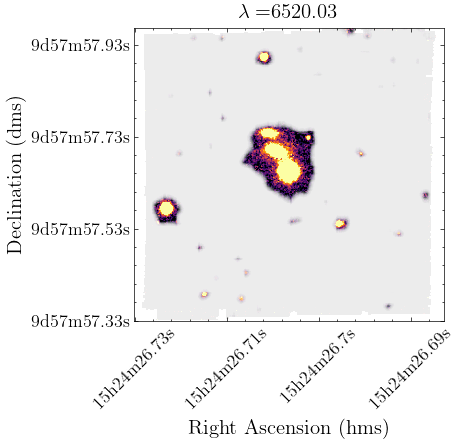

In [34]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.imshow(spec_cube[wav_plot_idx,:,:], cmap='inferno',
         vmin = 0, vmax = 10)

#ax.plot(circ_x_1, circ_y_1, color='gray', lw=2)
#ax.plot(circ_x_2, circ_y_2, color='gray', lw=2)

ax.scatter(seg_map_bg_x, seg_map_bg_y, color='white', marker='s',alpha=.05)

ax.set_title(r'$\lambda = $' + str(np.round(wav_arr[wav_plot_idx], 2)), fontsize=15)
ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
ax.set_yticklabels(Dec_arr_labels, fontsize=13)

ax.set_xlabel('Right Ascension (hms)', fontsize=15)
ax.set_ylabel('Declination (dms)', fontsize=15)

ax.invert_yaxis()

Carve out aperture for quasar and get its spectrum

In [35]:
qso_ref_pix_x = 168 
qso_ref_pix_y = 162

In [36]:
x = np.arange(seg_map.shape[0])
y = np.arange(seg_map.shape[1])

X,Y = np.meshgrid(x,y)

In [39]:
r_QSO = 15
qso_y, qso_x = np.where((X-qso_ref_pix_x)**2+(Y-qso_ref_pix_y)**2<r_QSO**2)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_62140/2639670612.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_62140/2639670612.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(Dec_arr_labels, fontsize=13)


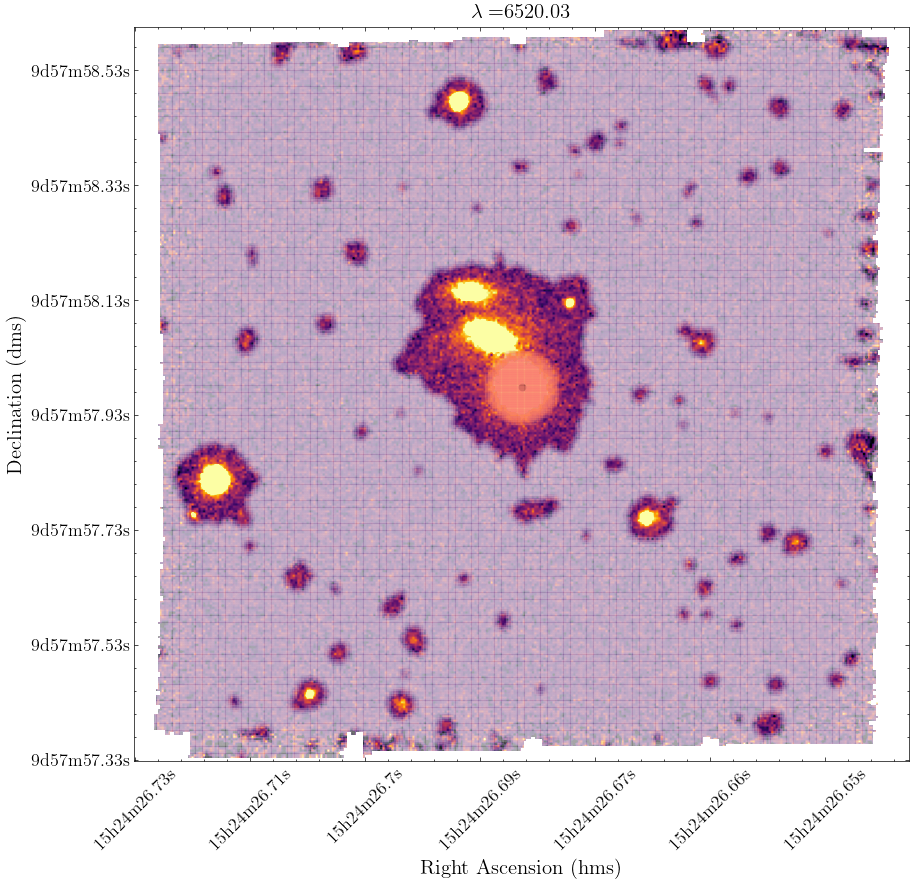

In [41]:
fig, ax = plt.subplots(1, figsize=(10,10))

ax.imshow(spec_cube[wav_plot_idx,:,:], cmap='inferno',
         vmin = -5.5, vmax = 13.5)

#ax.plot(circ_x_1, circ_y_1, color='gray', lw=2)
#ax.plot(circ_x_2, circ_y_2, color='gray', lw=2)

ax.scatter(seg_map_bg_x, seg_map_bg_y, color='white', marker='s',alpha=.05)
ax.scatter(qso_ref_pix_x, qso_ref_pix_y, s=20)
ax.scatter(qso_x, qso_y, color='salmon', marker='s',alpha=.1)

ax.set_title(r'$\lambda = $' + str(np.round(wav_arr[wav_plot_idx], 2)), fontsize=15)
ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
ax.set_yticklabels(Dec_arr_labels, fontsize=13)

ax.set_xlabel('Right Ascension (hms)', fontsize=15)
ax.set_ylabel('Declination (dms)', fontsize=15)

ax.invert_yaxis()

In [78]:
spec_qso = np.zeros(len(wav_arr))
err_qso = np.zeros(len(wav_arr))

In [79]:
flux_gal = np.zeros(len(qso_x))
spec_stack = np.zeros((len(qso_x), len(wav_arr)))
var_stack = np.zeros((len(qso_x), len(wav_arr)))

for j in range(len(qso_x)):

    x = qso_x[j]
    y = qso_y[j]

    spec_stack[j,:] = spec_cube[:,y,x]
    var_stack[j,:] = var_cube[:,y,x]

spec_qso = np.nanmean(spec_stack, axis=0)
err_qso = np.sqrt(np.nansum(var_stack, axis=0))/len(qso_x)

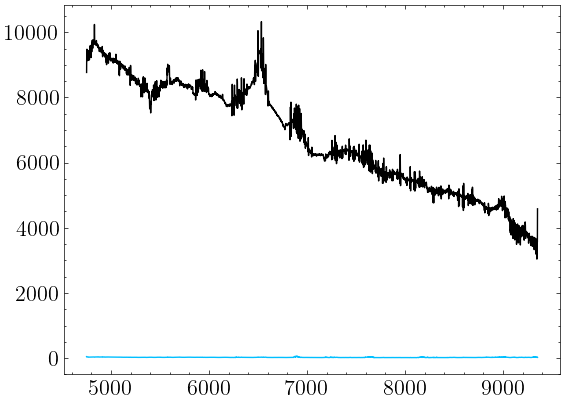

In [80]:
plt.plot(wav_arr, spec_qso)
plt.plot(wav_arr, err_qso)

In [42]:
np.savetxt(rootdir + 'qso_spec.dat',
          np.vstack((wav_arr, spec_qso, err_qso)).T, delimiter='\t')

But exclude the quasar from the search - use aperture from SExtractor

In [43]:
qso_id = seg_map[qso_ref_pix_y, qso_ref_pix_x]

In [44]:
qso_id

53

In [45]:
seg_map_qso_y, seg_map_qso_x = np.where(seg_map==qso_id)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_45252/467522209.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_45252/467522209.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(Dec_arr_labels, fontsize=13)


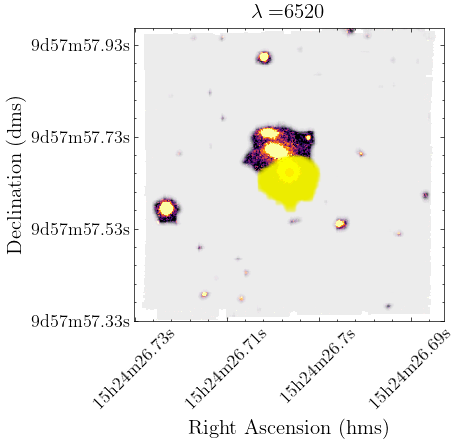

In [46]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.imshow(spec_cube[wav_plot_idx,:,:], vmin = 0, vmax = 10, cmap='inferno')

#ax.plot(circ_x_1, circ_y_1, color='gray', lw=2)
#ax.plot(circ_x_2, circ_y_2, color='gray', lw=2)

ax.scatter(qso_ref_pix_x, qso_ref_pix_y, color='red', s= 20)

ax.scatter(seg_map_bg_x, seg_map_bg_y, color='white', marker='s',alpha=.05)
ax.scatter(seg_map_qso_x, seg_map_qso_y, color='yellow', marker='s',alpha=.05)

ax.set_title(r'$\lambda = $' + str(np.round(wav_plot, 2)), fontsize=15)
ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
ax.set_yticklabels(Dec_arr_labels, fontsize=13)

ax.set_xlabel('Right Ascension (hms)', fontsize=15)
ax.set_ylabel('Declination (dms)', fontsize=15)

ax.invert_yaxis()

Load in the segmentation map for galaxy IDs

In [47]:
cat_file = np.loadtxt(rootdir + 'test.cat')

In [48]:
gal_ids_arr = np.int_(cat_file[:,0])

In [49]:
spec_master_stack = np.zeros((len(gal_ids_arr), len(wav_arr)))
err_master_stack = np.zeros((len(gal_ids_arr), len(wav_arr)))

In [51]:
for i in range(len(gal_ids_arr)):
    
    gal_id = gal_ids_arr[i]
    
    seg_map_gal_y, seg_map_gal_x = np.where(seg_map==gal_id)
   
    flux_gal = np.zeros(len(seg_map_gal_x))
    spec_stack = np.zeros((len(seg_map_gal_x), len(wav_arr)))
    var_stack = np.zeros((len(seg_map_gal_x), len(wav_arr)))
    
    for j in range(len(seg_map_gal_x)):
        
        x = seg_map_gal_x[j]
        y = seg_map_gal_y[j]

        flux_gal[j] = np.nansum(spec_cube[:,y,x])
        spec_stack[j,:] = spec_cube[:,y,x]
        var_stack[j,:] = var_cube[:,y,x]
        
    min_flux_gal = np.nanpercentile(flux_gal, 75)
    max_flux_gal = np.nanpercentile(flux_gal, 100)
    
    idx_bright = (flux_gal>=min_flux_gal) & (flux_gal<=max_flux_gal)
    
    spec_master_stack[i,:] = np.nanmean(spec_stack[idx_bright], axis=0)
    # Only normalize by pixels that are bright enough
    err_master_stack[i,:] = np.sqrt(np.nansum(var_stack[idx_bright], axis=0))/len(flux_gal[idx_bright])
    
    print(len(flux_gal[idx_bright])/len(seg_map_gal_x))

0.2529411764705882
0.2558139534883721
0.2558139534883721
0.25
0.25
0.25517241379310346
0.2571428571428571
0.2564102564102564
0.25675675675675674
0.2542372881355932
0.2608695652173913
0.25675675675675674
0.2727272727272727
0.2653061224489796
0.2571428571428571
0.26
0.2608695652173913
0.25609756097560976
0.28
0.25396825396825395
0.25
0.2857142857142857
0.25
0.2702702702702703
0.25252525252525254
0.25806451612903225
0.2537313432835821
0.2505399568034557


/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_45252/2456311938.py:25: RuntimeWarning: Mean of empty slice
  spec_master_stack[i,:] = np.nanmean(spec_stack[idx_bright], axis=0)


0.25149700598802394
0.25021496130696474
0.25
0.25862068965517243
0.25
0.2564102564102564
0.25
0.25806451612903225
0.2619047619047619
0.26666666666666666
0.25
0.2727272727272727
0.3333333333333333
0.26666666666666666
0.25274725274725274
0.2558139534883721
0.25
0.2564102564102564
0.2702702702702703
0.2641509433962264
0.25
0.28
0.25
0.2529411764705882
0.25
0.25225225225225223
0.2857142857142857
0.2857142857142857
0.2682926829268293
0.2727272727272727
0.25210084033613445
0.28
0.2549019607843137
0.2608695652173913
0.25
0.25287356321839083
0.29411764705882354
0.2608695652173913
0.25
0.2727272727272727
0.25
0.25757575757575757
0.25
0.2682926829268293
0.2564102564102564
0.2608695652173913
0.3333333333333333
0.2727272727272727
0.25
0.25
0.2564102564102564
0.2553191489361702


Text(0, 0.5, 'Flux (1e-20 erg/s/cm${}^2$/Å)')

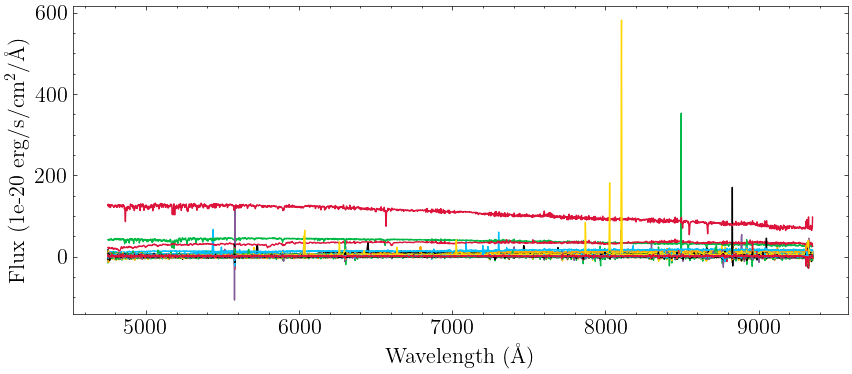

In [52]:
fig, ax = plt.subplots(1, figsize=(10,4))

for i in range(len(gal_ids_arr)):
    ax.plot(wav_arr, spec_master_stack[i,:])

ax.set_xlabel('Wavelength (Å)')
ax.set_ylabel(r'Flux (1e-20 erg/s/cm${}^2$/Å)')

#ax.set_ylim(0,7.2)
#ax.legend()

Text(0, 0.5, 'Flux (1e-20 erg/s/cm${}^2$/Å)')

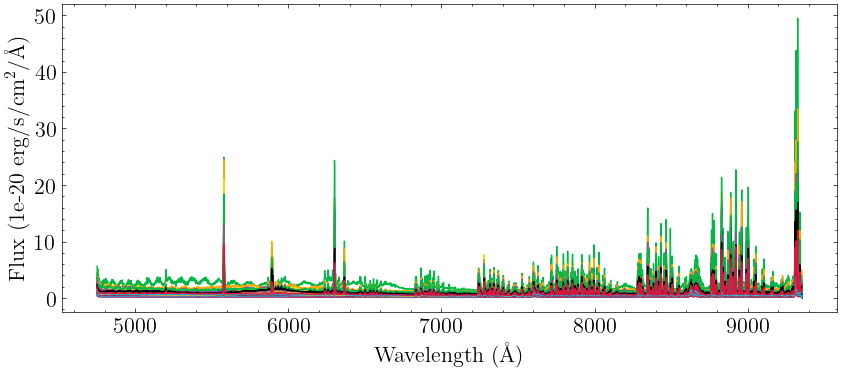

In [53]:
fig, ax = plt.subplots(1, figsize=(10,4))

for i in range(len(gal_ids_arr)):
    ax.plot(wav_arr, err_master_stack[i,:])

ax.set_xlabel('Wavelength (Å)')
ax.set_ylabel(r'Flux (1e-20 erg/s/cm${}^2$/Å)')

#ax.set_ylim(0,7.2)
#ax.legend()

Load in the galaxy eigenspectra

In [54]:
eigenspec_df = pd.read_csv('/Users/thepoetoftwilight/Documents/CUBS/Data/Eigenspectra/eigen_galaxy_Bolton2012.csv')

In [55]:
wav_eigen = eigenspec_df['wav']
c1 = eigenspec_df['c1']
c2 = eigenspec_df['c2']
c3 = eigenspec_df['c3']
c4 = eigenspec_df['c4']

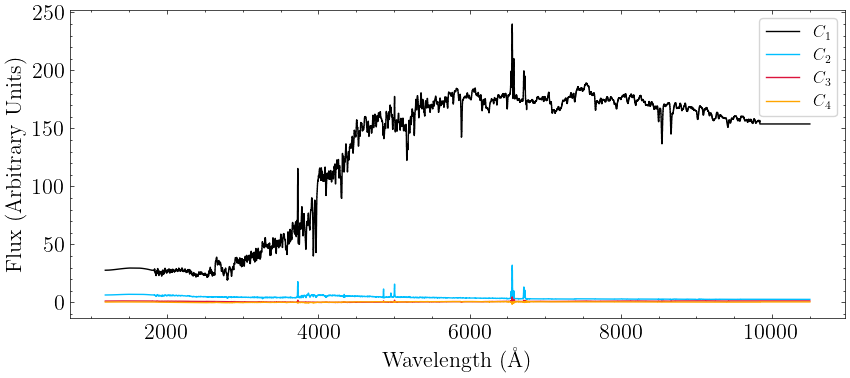

In [56]:
fig, ax = plt.subplots(1, figsize=(10,4))

ax.step(wav_eigen, c1, where='mid', label=r'$C_1$')
ax.step(wav_eigen, c2, where='mid', label=r'$C_2$')
ax.step(wav_eigen, c3, where='mid', label=r'$C_3$')
ax.step(wav_eigen, c4, where='mid', label=r'$C_4$')

ax.set_xlabel('Wavelength (Å)')
ax.set_ylabel('Flux (Arbitrary Units)')

ax.legend()

First obtain the redshift for a known galaxy

In [57]:
wav_plot = 9000
wav_plot_idx = np.argmin(np.abs(wav_arr-wav_plot))

In [58]:
gal_ex_id = 87

In [59]:
seg_map_gal_ex_y, seg_map_gal_ex_x = np.where(seg_map==gal_ex_id)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_45252/284775935.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_45252/284775935.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(Dec_arr_labels, fontsize=13)


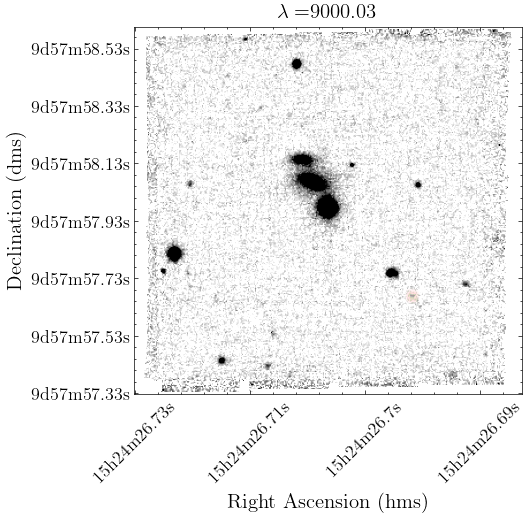

In [60]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.imshow(spec_cube[wav_plot_idx,:,:], vmin = 0, vmax = 10, cmap='binary')

#ax.plot(circ_x_1, circ_y_1, color='gray', lw=2)
#ax.plot(circ_x_2, circ_y_2, color='gray', lw=2)

#ax.scatter(qso_ref_pix_x, qso_ref_pix_y, color='red', s= 20)

ax.scatter(seg_map_gal_ex_x, seg_map_gal_ex_y, color='peachpuff', marker='s',alpha=.01)
#ax.scatter(gal_1_x_pix, gal_1_y_pix, color='red', s= 20)

ax.set_title(r'$\lambda = $' + str(np.round(wav_arr[wav_plot_idx], 2)), fontsize=15)
ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
ax.set_yticklabels(Dec_arr_labels, fontsize=13)

ax.set_xlabel('Right Ascension (hms)', fontsize=15)
ax.set_ylabel('Declination (dms)', fontsize=15)

ax.invert_yaxis()

In [61]:
gal_spec = spec_master_stack[np.where(gal_ids_arr == gal_ex_id)[0][0],:]
gal_spec_err = err_master_stack[np.where(gal_ids_arr == gal_ex_id)[0][0], :]

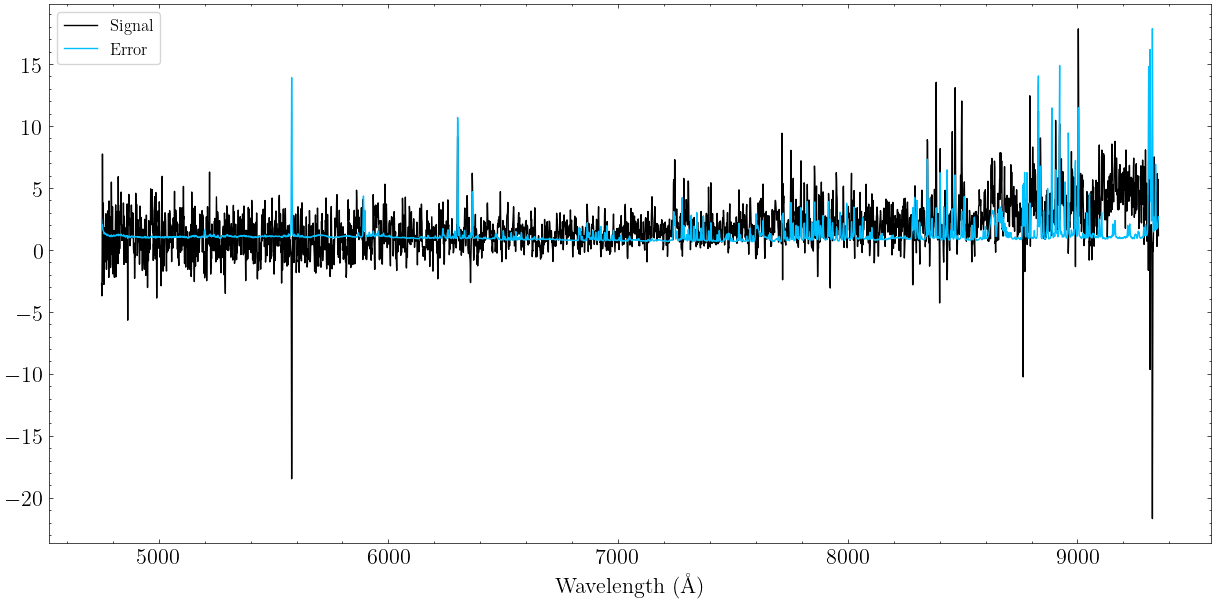

In [62]:
fig, ax = plt.subplots(1, figsize=(15,7))

ax.plot(wav_arr, gal_spec, label='Signal')
ax.plot(wav_arr, gal_spec_err, label='Error')

ax.set_xlabel('Wavelength (Å)')
#ax.set_ylabel('Flux (1e-20 erg/s/cm^2/Å)')

#ax.set_ylim(0,7.2)

ax.legend()

Now do the fitting

In [63]:
def z_shift_eigen(z, wav_arr):
    
    wav_eigen_shift = wav_eigen*(1+z)
    
    gal_ind = (wav_eigen_shift>=wav_arr[0])&(wav_eigen_shift<=wav_arr[-1])
    wav_eigen_shift_gal = wav_eigen_shift[gal_ind]
    
    c1_gal = c1[gal_ind]
    c1_gal_interp = np.interp(wav_arr, wav_eigen_shift_gal, c1_gal)

    c2_gal = c2[gal_ind]
    c2_gal_interp = np.interp(wav_arr, wav_eigen_shift_gal, c2_gal)
    
    c3_gal = c3[gal_ind]
    c3_gal_interp = np.interp(wav_arr, wav_eigen_shift_gal, c3_gal)

    c4_gal = c4[gal_ind]
    c4_gal_interp = np.interp(wav_arr, wav_eigen_shift_gal, c4_gal)
    
    return c1_gal_interp, c2_gal_interp, c3_gal_interp, c4_gal_interp

In [64]:
def best_model(c1, c2, c3, c4, y, y_err):

    A11 = np.sum((c1/y_err)**2)
    A12 = np.sum(c1*c2/y_err**2)
    A13 = np.sum(c1*c3/y_err**2)
    A14 = np.sum(c1*c4/y_err**2)
    
    A21 = np.sum(c2*c1/y_err**2)
    A22 = np.sum((c2/y_err)**2)
    A23 = np.sum(c2*c3/y_err**2)
    A24 = np.sum(c2*c4/y_err**2)
    
    A31 = np.sum(c3*c1/y_err**2)
    A32 = np.sum(c3*c2/y_err**2)
    A33 = np.sum((c3/y_err)**2)
    A34 = np.sum(c3*c4/y_err**2)
    
    A41 = np.sum(c4*c1/y_err**2)
    A42 = np.sum(c4*c2/y_err**2)
    A43 = np.sum(c4*c3/y_err**2)
    A44 = np.sum((c4/y_err)**2)
    
    b1 = np.sum(y*c1/y_err**2)
    b2 = np.sum(y*c2/y_err**2)
    b3 = np.sum(y*c3/y_err**2)
    b4 = np.sum(y*c4/y_err**2)
    
    A_mat = np.array([[A11, A12, A13, A14],[A21, A22, A23, A24],[A31, A32, A33, A34],[A41, A42, A43, A44]])
    b_vec = np.array([b1, b2, b3, b4])
    
    x_vec = np.linalg.inv(A_mat)@b_vec
    
    a = x_vec[0]
    b = x_vec[1]
    c = x_vec[2]
    d = x_vec[3]

    return a, b, c, d

In [65]:
def eval_red_chi_sq(y_hat, y, y_err, dof):
    
    return np.sum(((y-y_hat)/y_err)**2)/(len(y)-dof)

In [66]:
z_arr = np.arange(-0.1,1.4,1e-4)
red_chi_sq_arr = np.zeros(len(z_arr))

In [67]:
model_params = np.zeros((len(z_arr), 4))

In [68]:
idx = ~np.isnan(gal_spec)

In [69]:
for i in range(len(z_arr)):
    
    z = z_arr[i]
    
    c1_shift, c2_shift, c3_shift, c4_shift = z_shift_eigen(z, wav_arr[idx][20:-20])
    
    a, b, c, d = best_model(c1_shift, c2_shift, c3_shift, c4_shift, 
                            gal_spec[idx][20:-20], gal_spec_err[idx][20:-20])
    
    model_params[i,0] = a
    model_params[i,1] = b
    model_params[i,2] = c
    model_params[i,3] = d 
    
    red_chi_sq = eval_red_chi_sq(a*c1_shift+b*c2_shift+c*c3_shift+d*c4_shift, 
                                        gal_spec[idx][20:-20], gal_spec_err[idx][20:-20], model_params.shape[1])
    
    red_chi_sq_arr[i] = red_chi_sq
    
    #print(a, b, c, d, red_chi_sq)

1.2787000000000395 1.4498928726134561


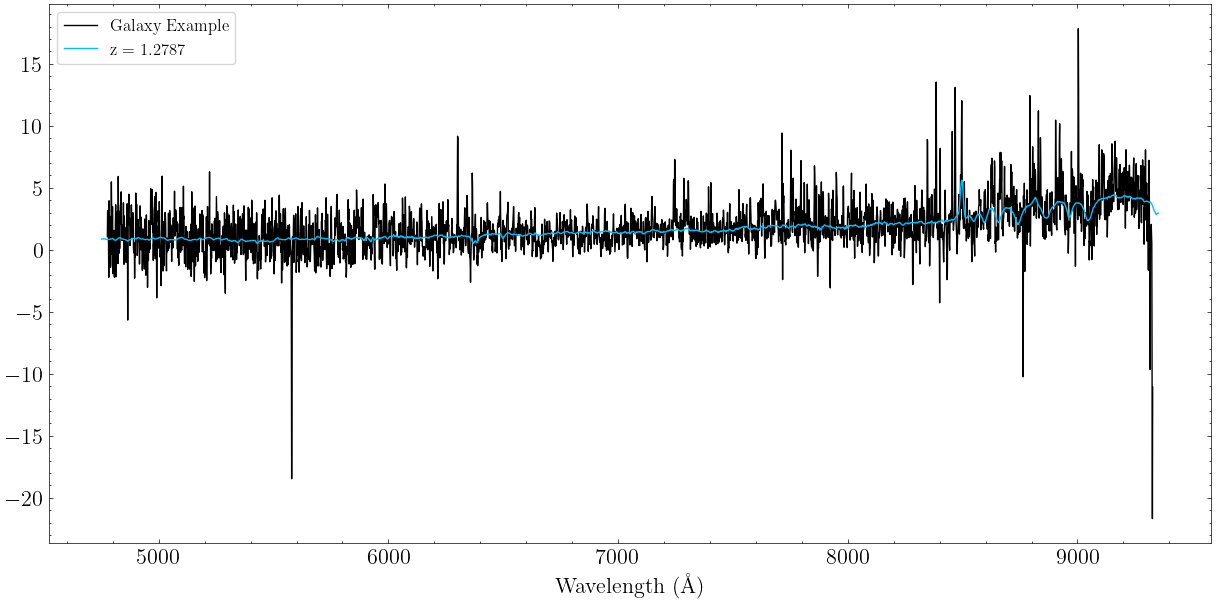

In [70]:
fig, ax = plt.subplots(1, figsize=(15,7))

ax.plot(wav_arr[idx][20:-20], gal_spec[idx][20:-20], label='Galaxy Example')

z = z_arr[np.argmin(red_chi_sq_arr)]

print(z, np.min(red_chi_sq_arr))

c1_shift, c2_shift, c3_shift, c4_shift = z_shift_eigen(z, wav_arr)

ax.plot(wav_arr, model_params[np.argmin(red_chi_sq_arr),0]*c1_shift + model_params[np.argmin(red_chi_sq_arr),1]*c2_shift + model_params[np.argmin(red_chi_sq_arr),2]*c3_shift + model_params[np.argmin(red_chi_sq_arr),3]*c4_shift, 
        label='z = ' + str(np.round(z,4)))

ax.set_xlabel('Wavelength (Å)')
#ax.set_ylabel('Flux (1e-20 erg/s/cm^2/Å)')

#ax.set_ylim(0,7.2)

ax.legend()

Text(0, 0.5, '$\\chi^2$')

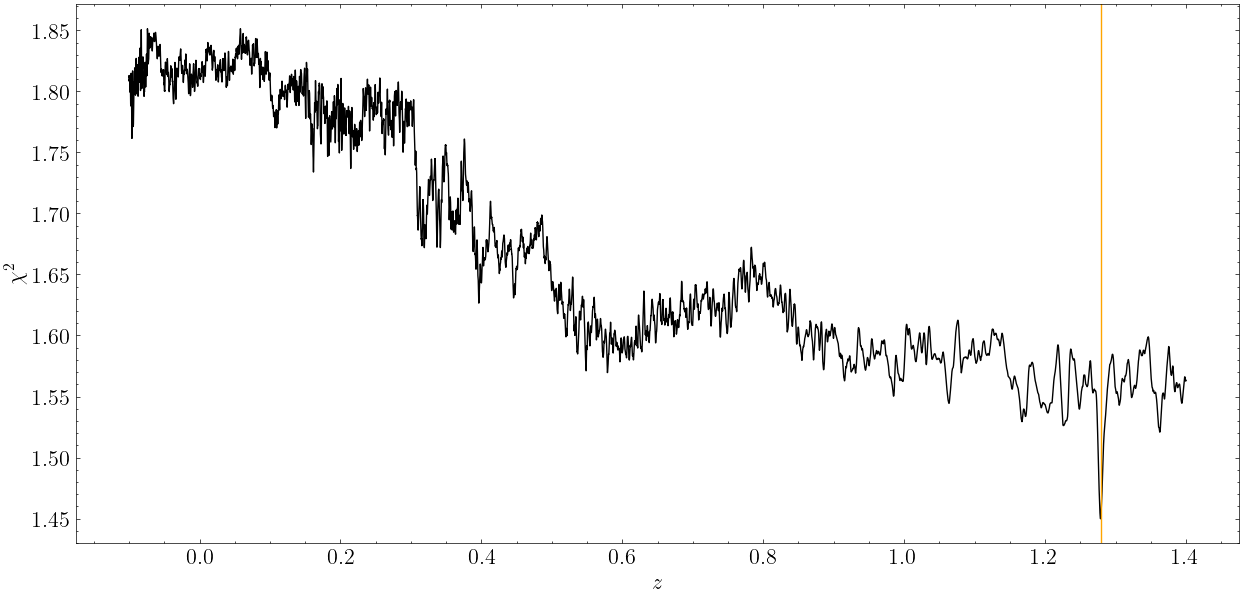

In [71]:
fig, ax = plt.subplots(1, figsize=(15,7))

ax.plot(z_arr, red_chi_sq_arr)
ax.axvline(z_arr[np.argmin(red_chi_sq_arr)],color='orange')

ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\chi^2$')

Now do it for all galaxies

In [72]:
z_arr_gal = np.zeros(len(gal_ids_arr))

spec_master_fit_stack = np.zeros((len(gal_ids_arr), len(wav_arr)))

In [73]:
gal_ids_arr

array([  1,   2,   3,   5,  18,  19,  20,  23,  25,  26,  27,  28,  30,
        32,  33,  34,  35,  36,  38,  39,  40,  42,  43,  44,  45,  47,
        48,  49,  50,  51,  52,  56,  57,  58,  59,  61,  64,  65,  66,
        67,  68,  69,  70,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        82,  83,  84,  85,  86,  87,  88,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 102, 103, 104, 105, 107, 109, 114, 115,
       122, 123])

In [74]:
for i in range(len(gal_ids_arr)):
        
    gal_id = gal_ids_arr[i]
    if gal_id in [105, 27, 58, 87]:

        gal_spec = spec_master_stack[i,:]
        gal_spec_err = err_master_stack[i,:]

        idx = ~np.isnan(gal_spec)

        red_chi_sq_arr = np.zeros(len(z_arr))
        a_arr = np.zeros(len(z_arr))
        b_arr = np.zeros(len(z_arr))
        c_arr = np.zeros(len(z_arr))
        d_arr = np.zeros(len(z_arr))

        n_trim = 20

        for j in range(len(z_arr)):

            z = z_arr[j]

            c1_shift, c2_shift, c3_shift, c4_shift = z_shift_eigen(z, wav_arr[idx][n_trim:-n_trim])

            a, b, c, d = best_model(c1_shift, c2_shift, c3_shift, c4_shift, 
                                    gal_spec[idx][n_trim:-n_trim], gal_spec_err[idx][n_trim:-n_trim])

            a_arr[j] = a
            b_arr[j] = b
            c_arr[j] = c
            d_arr[j] = d 

            red_chi_sq = eval_red_chi_sq(a*c1_shift+b*c2_shift+c*c3_shift+d*c4_shift, 
                                                gal_spec[idx][n_trim:-n_trim], 
                                         gal_spec_err[idx][n_trim:-n_trim], model_params.shape[1])

            red_chi_sq_arr[j] = red_chi_sq

            #print(a, b, c, d, red_chi_sq)

        #os.mkdir(rootdir + 'gal' + str(gal_id))

        np.savetxt(rootdir + 'gal{}/gal{}_model.dat'.format(gal_id,gal_id), 
                   np.vstack((z_arr, a_arr, b_arr, c_arr, d_arr, red_chi_sq_arr)).T,
                  delimiter = '\t')

        min_arg = np.argmin(red_chi_sq_arr)

        best_z = z_arr[min_arg]
        best_red_chi_sq = np.min(red_chi_sq_arr)

        #z_arr_gal[i] = best_z

        c1_shift, c2_shift, c3_shift, c4_shift = z_shift_eigen(best_z, wav_arr)

        fit = a_arr[min_arg]*c1_shift + b_arr[min_arg]*c2_shift + c_arr[min_arg]*c3_shift + d_arr[min_arg]*c4_shift    

        #spec_master_fit_stack[i,:] = fit

        np.savetxt(rootdir + 'gal{}/gal{}_spec.dat'.format(gal_id,gal_id),
                  np.vstack((wav_arr, gal_spec, gal_spec_err, fit)).T, delimiter='\t')

        print('Done fitting galaxy ' + str(i+1) + '/' + str(len(gal_ids_arr)) + ', z = ' + str(np.round(best_z, 4)) + ', chi2 = ' + str(np.round(best_red_chi_sq, 4)))

Done fitting galaxy 11/80, z = 0.1907, chi2 = 1.6128
Done fitting galaxy 34/80, z = 1.2256, chi2 = 1.624
Done fitting galaxy 58/80, z = 1.2787, chi2 = 1.4499
Done fitting galaxy 74/80, z = 0.5134, chi2 = 1.5833


Load in catalog file

In [75]:
with open(rootdir+'test.cat') as file:
    lines = [line.rstrip() for line in file]

In [73]:
header_lines = lines[0:12]
header_lines.append('#  13 REDSHIFT               Best-fit object redshift')
header_lines

['#   1 NUMBER                 Running object number',
 '#   2 X_WORLD                Barycenter position along world x axis                     [deg]',
 '#   3 Y_WORLD                Barycenter position along world y axis                     [deg]',
 '#   4 X_IMAGE                Object position along x                                    [pixel]',
 '#   5 Y_IMAGE                Object position along y                                    [pixel]',
 '#   6 ISOAREA_IMAGE          Isophotal area above Analysis threshold                    [pixel**2]',
 '#   7 MAG_ISOCOR             Corrected isophotal magnitude                              [mag]',
 '#   8 MAGERR_ISOCOR          RMS error for corrected isophotal magnitude                [mag]',
 '#   9 MAG_AUTO               Kron-like elliptical aperture magnitude                    [mag]',
 '#  10 MAGERR_AUTO            RMS error for AUTO magnitude                               [mag]',
 '#  11 KRON_RADIUS            Kron apertures in units

In [74]:
data_lines = lines[12:]

In [75]:
for i in range(len(z_arr_gal)):
    data_lines[i] += '  ' + str(np.round(z_arr_gal[i], 4))

In [76]:
data_lines

['         1   2.3110729601e+02   9.9674542527e+00     76.8023     29.5341       145  22.3694   0.0635  22.3976   0.0653  3.50  0.966  0.5356',
 '         2   2.3110505075e+02   9.9672076093e+00    116.6069     25.0939       102  22.5532   0.0691  22.6004   0.0717  3.50  0.877  0.4581',
 '         3   2.3109604199e+02   9.9667476800e+00    276.3172     16.8158        99  23.6237   0.1120  23.8783   0.1346  3.50  0.013  0.9576',
 '         5   2.3110397012e+02   9.9667033084e+00    135.7645     16.0164        40  24.4609   0.1648  24.6197   0.1891  3.50  0.979  0.8217',
 '        18   2.3110362791e+02   9.9817730356e+00    141.8330    287.2714       372  19.3019   0.0155  19.3245   0.0157  3.50  0.988  -0.0005',
 '        19   2.3109836935e+02   9.9832855158e+00    235.0540    314.4963       108  23.2204   0.0933  23.3125   0.1015  3.50  0.027  0.4784',
 '        20   2.3109732470e+02   9.9830867728e+00    253.5729    310.9191        85  23.5250   0.1074  23.6204   0.1170  3.50  0.511  

In [77]:
lines_new = header_lines + data_lines
lines_new

['#   1 NUMBER                 Running object number',
 '#   2 X_WORLD                Barycenter position along world x axis                     [deg]',
 '#   3 Y_WORLD                Barycenter position along world y axis                     [deg]',
 '#   4 X_IMAGE                Object position along x                                    [pixel]',
 '#   5 Y_IMAGE                Object position along y                                    [pixel]',
 '#   6 ISOAREA_IMAGE          Isophotal area above Analysis threshold                    [pixel**2]',
 '#   7 MAG_ISOCOR             Corrected isophotal magnitude                              [mag]',
 '#   8 MAGERR_ISOCOR          RMS error for corrected isophotal magnitude                [mag]',
 '#   9 MAG_AUTO               Kron-like elliptical aperture magnitude                    [mag]',
 '#  10 MAGERR_AUTO            RMS error for AUTO magnitude                               [mag]',
 '#  11 KRON_RADIUS            Kron apertures in units

In [78]:
with open(rootdir+'test_new.cat', 'w') as f:
    for line in lines_new:
        f.write(f"{line}\n")

Plot redshifts

In [79]:
gal_centers_x = cat_file[:,3]
gal_centers_y = cat_file[:,4]

In [80]:
plot_wav = wav_arr[n]

<ipython-input-81-2c5f17cfce8c>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
<ipython-input-81-2c5f17cfce8c>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(Dec_arr_labels, fontsize=13)


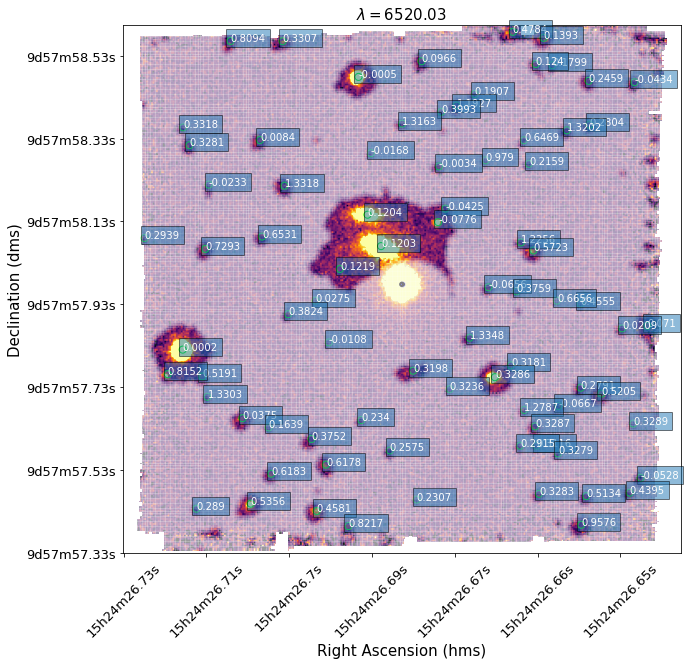

In [81]:
fig, ax = plt.subplots(1, figsize=(10,10))

ax.imshow(spec_arr, vmin = min_flux, vmax = max_flux, cmap='inferno')

ax.plot(circ_x_1, circ_y_1, color='gray', lw=2)
ax.plot(circ_x_2, circ_y_2, color='gray', lw=2)

ax.scatter(qso_ref_pix_x, qso_ref_pix_y, color='blue', s= 20)
ax.scatter(gal_centers_x, gal_centers_y,  facecolors='none', edgecolors='lime', s=50)

ax.scatter(seg_map_bg_x, seg_map_bg_y, color='white', marker='s',alpha=.05)
ax.scatter(seg_map_qso_x, seg_map_qso_y, color='white', marker='s',alpha=.05)

for i in range(len(z_arr_gal)):
    x = gal_centers_x[i]
    y = gal_centers_y[i]
    ax.text(x, y, str(np.round(z_arr_gal[i],5)), color='white', bbox={'alpha':.5})


ax.set_title(r'$\lambda = $' + str(np.round(plot_wav, 2)), fontsize=15)
ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
ax.set_yticklabels(Dec_arr_labels, fontsize=13)

ax.set_xlabel('Right Ascension (hms)', fontsize=15)
ax.set_ylabel('Declination (dms)', fontsize=15)

ax.invert_yaxis()